In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential

## Load CIFAR-10 data 32*32

In [4]:
# Load CIFAR-10 data
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()    # y is label of x
print(len(cifar10_x_train))
print(len(cifar10_x_test))

50000
10000


## Load 128*128 data

In [2]:
def load_images_from_directory(directory_path, max_images=None):
    images = []
    files = os.listdir(directory_path)[:max_images]  # Limit the number of images if max_images is set
    for file in files:
        file_path = os.path.join(directory_path, file)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            with Image.open(file_path) as img:
                images.append(np.array(img))
    return images

# Load 128*128 data
directory_path = '/Users/yueyin/Downloads/128x128/landmark'
images = load_images_from_directory(directory_path, 30000)
images_np = np.array(images)
one_two_eight_train, one_two_eight_test = train_test_split(images_np, test_size=0.2)  # 20% of data for testing
print(len(one_two_eight_train))
print(len(one_two_eight_test))


24000
6000


## Normalize Data

In [5]:
def normalize_images(images):
    return images.astype('float32') / 255.

cifar10_x_train = normalize_images(cifar10_x_train)
cifar10_x_test = normalize_images(cifar10_x_test)
one_two_eight_train = normalize_images(one_two_eight_train)
one_two_eight_test = normalize_images(one_two_eight_test)

## Apply Masks

In [6]:
def apply_mask_and_get_small_masks(imgs, mask_size, location='center'):
    """
    Apply a mask to a given location on the images and return the masked images and the smaller masks.

    Parameters:
    - imgs: numpy array of images.
    - mask_size: Size of the mask.
    - location: Location of the mask ('center', 'upper_right', 'lower_left', 'upper_left', 'lower_right').

    Returns:
    - Tuple of masked images and smaller masks (only the size of the mask).
    """
    masked_imgs = imgs.copy()
    small_masks = np.ones((imgs.shape[0], mask_size, mask_size, imgs.shape[3]))  # Small masks with the same depth as images
    height, width = imgs.shape[1], imgs.shape[2]

    # Calculate the start position for each mask location
    if location == 'center':
        start_x = (width - mask_size) // 2
        start_y = (height - mask_size) // 2
    elif location == 'upper_right':
        start_x = width - mask_size
        start_y = 0
    elif location == 'lower_left':
        start_x = 0
        start_y = height - mask_size
    elif location == 'upper_left':
        start_x = 0
        start_y = 0
    elif location == 'lower_right':
        start_x = width - mask_size
        start_y = height - mask_size
    else:
        raise ValueError("Unknown mask location: {}".format(location))

    # Apply the mask to the images and extract the mask region
    for i in range(imgs.shape[0]):
        masked_imgs[i, start_y:start_y+mask_size, start_x:start_x+mask_size, :] = 0
        small_masks[i] = imgs[i, start_y:start_y+mask_size, start_x:start_x+mask_size, :]

    return masked_imgs, small_masks

### Apply mask at center 32*32

In [7]:
mask_size = 16  # Size of the mask
location = 'center'  # Location where the mask will be applied

cifar10_x_train_center_masked, cifar10_x_train_center_masks = apply_mask_and_get_small_masks(cifar10_x_train, mask_size, location)
cifar10_x_test_center_masked, cifar10_x_test_center_masks = apply_mask_and_get_small_masks(cifar10_x_test, mask_size, location)


print(cifar10_x_train_center_masked[0].shape) # masked image shape
print(cifar10_x_train_center_masks[0].shape) # mask shape

(32, 32, 3)
(16, 16, 3)


### Apply mask at upper left 32*32

In [ ]:
mask_size = 16  # Size of the mask
location = 'upper_left'  # Location where the mask will be applied

cifar10_x_train_ul_masked, cifar10_x_train_ul_masks = apply_mask_and_get_small_masks(cifar10_x_train, mask_size, location)
cifar10_x_test_ul_masked, cifar10_x_test_ul_masks = apply_mask_and_get_small_masks(cifar10_x_test, mask_size, location)


print(cifar10_x_train_ul_masked[0].shape) # masked image shape
print(cifar10_x_train_ul_masks[0].shape) # mask shape

### Apply mask at center 128*128

In [59]:
mask_size = 32  # Size of the mask
location = 'center'  # Location where the mask will be applied

one_two_eight_train_masked, one_two_eight_train_masks = apply_mask_and_get_small_masks(one_two_eight_train, mask_size, location)
one_two_eight_test_masked, one_two_eight_test_masks = apply_mask_and_get_small_masks(one_two_eight_test, mask_size, location)

print(one_two_eight_train_masked[0].shape) # masked image shape
print(one_two_eight_train_masks[0].shape) # mask shape

(128, 128, 3)
(32, 32, 3)


## Visualize Masked Image 

In [60]:
def display_images(row_data, num_images=5, titles=None, save_path=None):
    """
    Display images in a 3-row layout, allowing specification of the datasets for each row,
    and optionally save the plot to a file.

    Parameters:
    - row_data: List of 3 numpy arrays, each representing a dataset for a row.
    - num_images: Number of images to display from each dataset (default is 5).
    - titles: List of titles for each row (default is None).
    - save_path: Path to save the plot (default is None, which means the plot won't be saved).
    """
    if titles is None:
        titles = ['Row 1', 'Row 2', 'Row 3']
    if len(row_data) != 3:
        raise ValueError("row_data must contain exactly three datasets.")
    if len(titles) != 3:
        raise ValueError("titles must contain exactly three strings.")

    fig, axs = plt.subplots(3, num_images, figsize=(3 * num_images, 6))
    for row_idx, dataset in enumerate(row_data):
        for img_idx in range(num_images):
            axs[row_idx, img_idx].imshow(dataset[img_idx])
            if img_idx == 0:
                axs[row_idx, img_idx].set_ylabel(titles[row_idx])
            axs[row_idx, img_idx].set_title(f'Image {img_idx + 1}')
            axs[row_idx, img_idx].axis('off')

    plt.tight_layout()

    # Save the plot if a save path is provided
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")

    plt.show()


### display 32*32

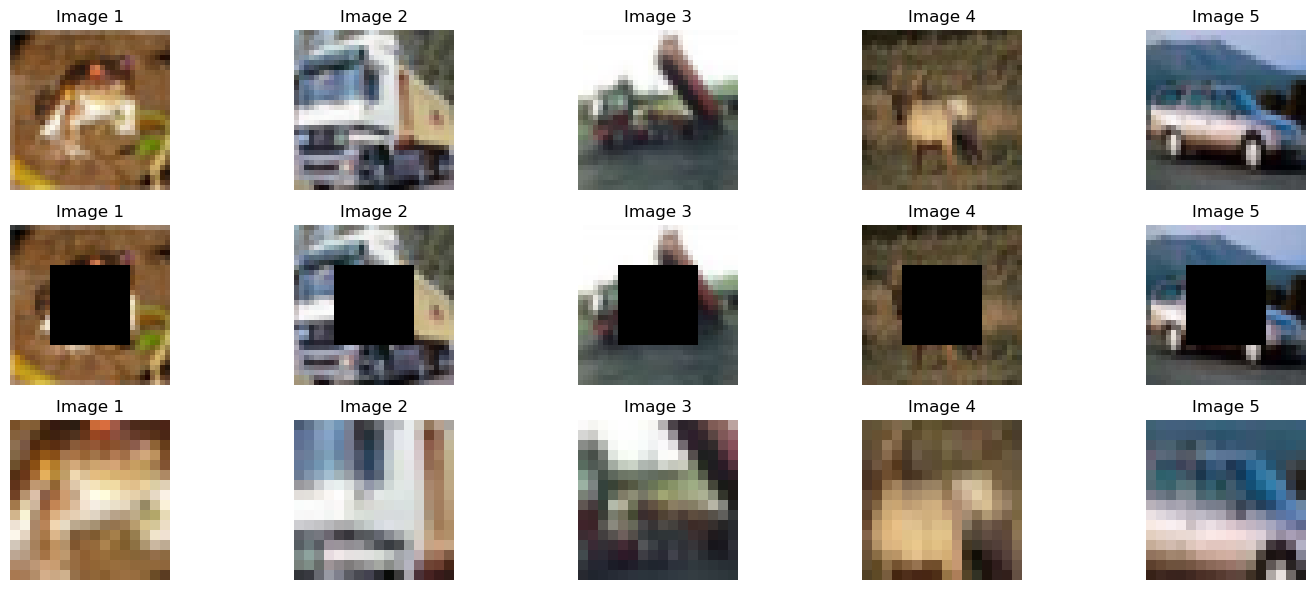

In [61]:
display_images(
    [cifar10_x_train, cifar10_x_train_center_masked, cifar10_x_train_center_masks],
    num_images=5,  # Number of images you want to display
    titles=['Original', 'Center Removed', 'Mask'],  # Titles for each row
    #save_path='comparison_plot.png'  # Path where the plot will be saved
)

### display 128*128

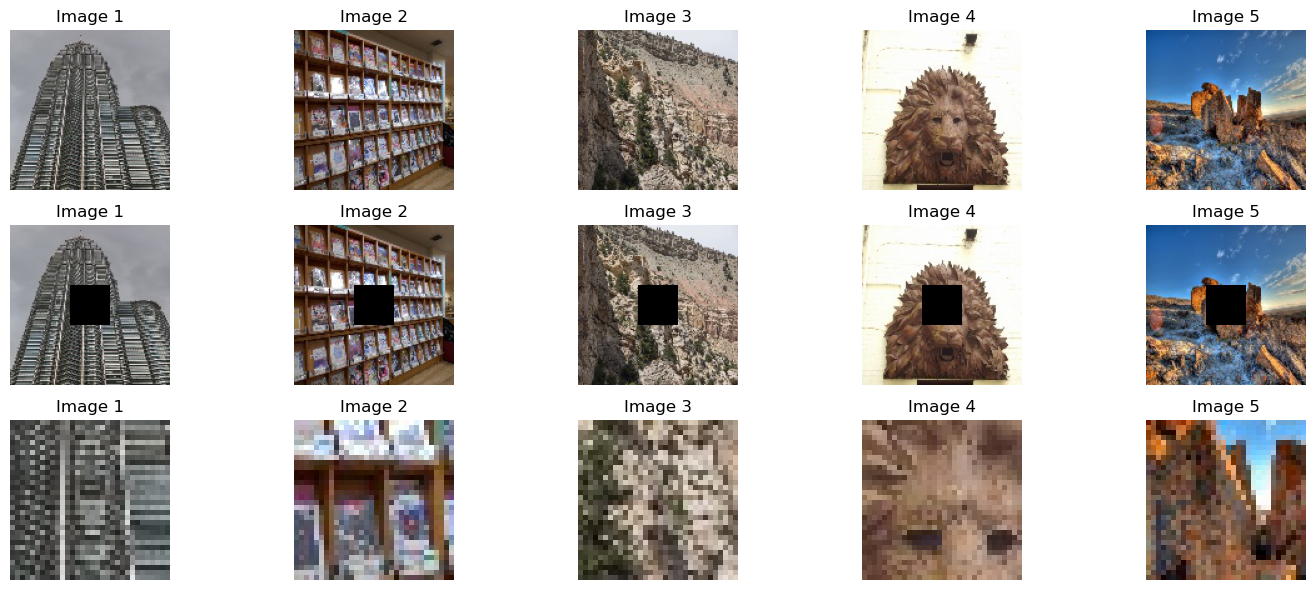

In [62]:
display_images(
    [one_two_eight_train, one_two_eight_train_masked, one_two_eight_train_masks],
    num_images=5,  # Number of images you want to display
    titles=['Original', 'Center Removed', 'Mask'],  # Titles for each row
    #save_path='comparison_plot.png'  # Path where the plot will be saved
)

## Helper Function

#### Insert Image back

In [12]:
def insert_generated_patch(original_images, generated_patches, patch_size, image_size, location='center'):
    """
    Insert generated patches into the original images at the specified location.

    Parameters:
    - original_images: numpy array of original images.
    - generated_patches: numpy array of patches to insert.
    - patch_size: size of the generated patches (assumes square patches).
    - image_size: size of the original images (assumes square images).
    - location: where to insert the patch. One of ['center', 'upper-left', 'lower-left', 'upper-right', 'lower-right'].
    
    Returns:
    - images with inserted patches.
    """
    
    # Calculate start indices based on location
    if location == 'center':
        start_x = (image_size - patch_size) // 2
        start_y = (image_size - patch_size) // 2
    elif location == 'upper-left':
        start_x = 0
        start_y = 0
    elif location == 'lower-left':
        start_x = 0
        start_y = image_size - patch_size
    elif location == 'upper-right':
        start_x = image_size - patch_size
        start_y = 0
    elif location == 'lower-right':
        start_x = image_size - patch_size
        start_y = image_size - patch_size
    else:
        raise ValueError("Unknown location. Available options: 'center', 'upper-left', 'lower-left', 'upper-right', 'lower-right'.")

    # Make a copy of the original images to avoid modifying the original array
    images_with_patches = np.copy(original_images)

    # Replace the specified location of each image with the generated patch
    images_with_patches[:, start_y:start_y+patch_size, start_x:start_x+patch_size, :] = generated_patches

    return images_with_patches

# Usage Example:
# insert_generated_patch(original_images, generated_patches, 16, 32, 'center')
# insert_generated_patch(original_images, generated_patches, 64, 128, 'center')


In [14]:
def mse(imageA, imageB):
    imageA = imageA.astype('float32')
    imageB = imageB.astype('float32')
    err = np.mean((imageA - imageB) ** 2)
    return err

### Early stop

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=7,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Encoder Decoder for 32 * 32

In [120]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dense, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input

def build_encoder_decoder_32(input_shape=(32, 32, 3), output_shape=(16, 16, 3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Ensuring we have a suitable feature map size

    # Fully Connected layer simulation (reshape -> dense -> reshape)
    x = Flatten()(encoded)
    x = Dense(4096, activation='relu')(x)  # Experiment with the size
    x = Reshape((4, 4, 256))(x)  # Adjust size based on Dense layer output

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)  # Adjust to target output size
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    decoded = Conv2D(output_shape[2], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=input_img, outputs=decoded)
    return model

encoder_decoder_32 = build_encoder_decoder_32()
encoder_decoder_32.compile(optimizer='adam', loss='mse')
encoder_decoder_32.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_185 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_155 (B  (None, 32, 32, 64)        256       
 atchNormalization)                                              
                                                                 
 max_pooling2d_108 (MaxPool  (None, 16, 16, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_186 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 batch_normalization_156 (B  (None, 16, 16, 128)       512

## Train the model 32 * 32

In [121]:
history_32 = encoder_decoder_32.fit(
    cifar10_x_train_center_masked, 
    cifar10_x_train_center_masks,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(cifar10_x_test_center_masked, cifar10_x_test_center_masks),
    callbacks=[early_stopping] 
)

Epoch 1/30
391/391 [==============================] - 30s 73ms/step - loss: 0.0308 - val_loss: 0.1074
Epoch 2/30
391/391 [==============================] - 26s 67ms/step - loss: 0.0260 - val_loss: 0.0267
Epoch 3/30
391/391 [==============================] - 27s 69ms/step - loss: 0.0248 - val_loss: 0.0287
Epoch 4/30
391/391 [==============================] - 26s 68ms/step - loss: 0.0240 - val_loss: 0.0282
Epoch 5/30
391/391 [==============================] - 27s 69ms/step - loss: 0.0233 - val_loss: 0.0253
Epoch 6/30
391/391 [==============================] - 27s 69ms/step - loss: 0.0225 - val_loss: 0.0249
Epoch 7/30
391/391 [==============================] - 27s 68ms/step - loss: 0.0218 - val_loss: 0.0252
Epoch 8/30
391/391 [==============================] - 26s 67ms/step - loss: 0.0209 - val_loss: 0.0259
Epoch 9/30
391/391 [==============================] - 27s 68ms/step - loss: 0.0200 - val_loss: 0.0271
Epoch 10/30
391/391 [==============================] - 26s 66ms/step - loss: 0.018

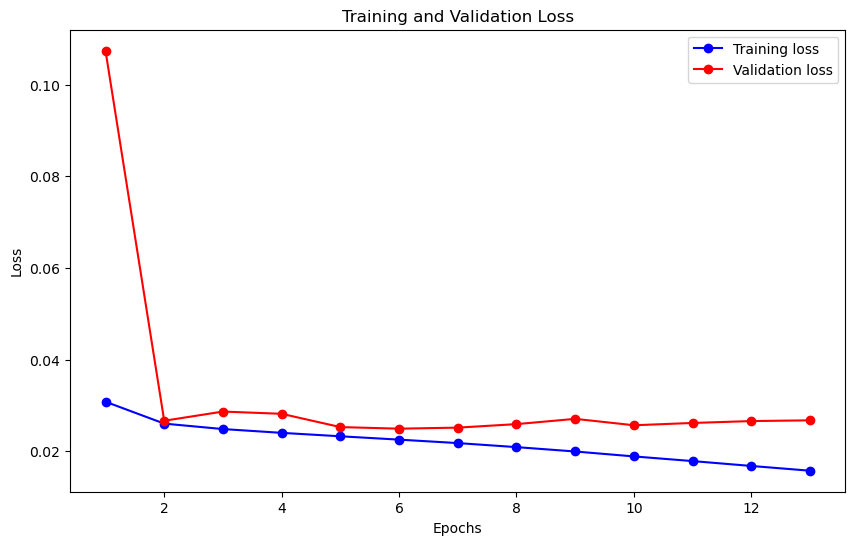

In [128]:
# Extracting loss and validation loss values
loss = history_32.history['loss']
val_loss = history_32.history['val_loss']

epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [123]:
generated_images_32 = encoder_decoder_32.predict(cifar10_x_test_center_masked[:])
image_with_center_32 = insert_generated_patch(cifar10_x_test_center_masked[:], generated_images_32, 16, 32, 'center')

313/313 [==============================] - 4s 12ms/step


#### Visualize Testing images

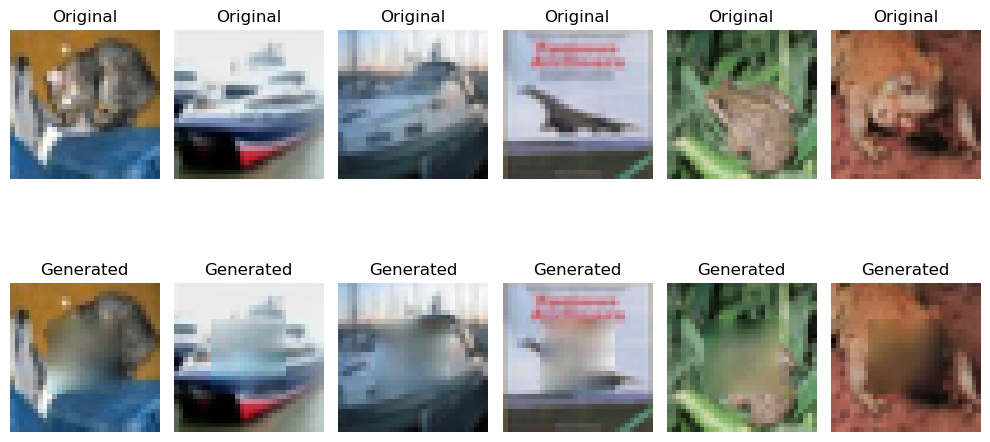

Average MSE: 0.024931039661169052


In [124]:
num_images = 6
fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(cifar10_x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center_32[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_images = len(cifar10_x_test_center_masks)
mse_values = []
for i in range(num_images):
    mse_values.append(mse(cifar10_x_test_center_masks[i], generated_images_32[i]))
average_mse = np.mean(mse_values)
print(f'Average MSE: {average_mse}')

#### Visualize Training images

In [125]:
generated_images_32 = encoder_decoder_32.predict(cifar10_x_train_center_masked[:])
image_with_center_32 = insert_generated_patch(cifar10_x_train_center_masked[:], generated_images_32, 16, 32, 'center')

1563/1563 [==============================] - 19s 12ms/step


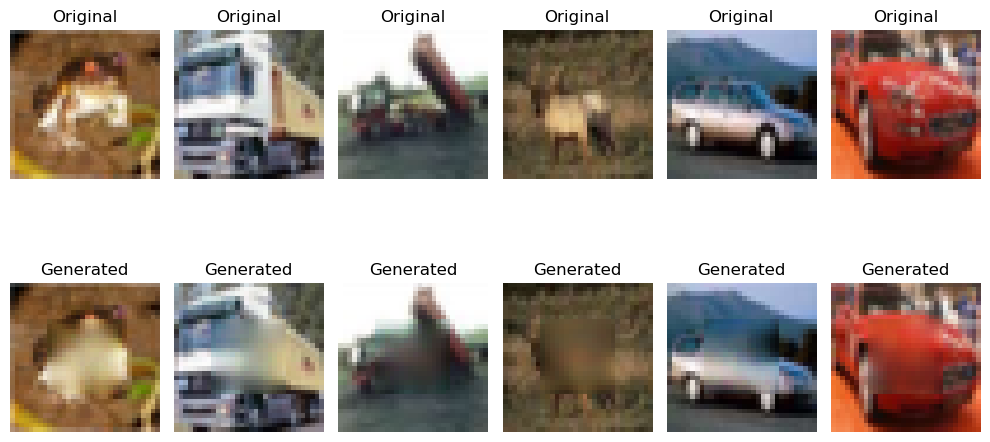

Average MSE: 0.021602313965559006


In [127]:
num_images = 6
fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(cifar10_x_train[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center_32[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_images = len(cifar10_x_train_center_masks)
mse_values = []
for i in range(num_images):
    mse_values.append(mse(cifar10_x_train_center_masks[i], generated_images_32[i]))
average_mse = np.mean(mse_values)
print(f'Average MSE: {average_mse}')

# Encoder Decoder for 128 * 128

In [129]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def build_encoder_decoder_128(input_shape=(128, 128, 3), output_shape=(32, 32, 3)):
    input_img = Input(shape=input_shape)

    # Encoder
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling2D((2, 2), padding='same')(x1) # 64x64x64
    
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling2D((2, 2), padding='same')(x2) # 32x32*128
    
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling2D((2, 2), padding='same')(x3) # 16x16x256
    
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x3)
    x4 = BatchNormalization()(x4)
    x4 = MaxPooling2D((2, 2), padding='same')(x4) # 8x8x512

    # Bottleneck
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x4) # 8x8x512

    # Decoder
    
    x = UpSampling2D((2, 2))(x) # 16x16x
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, x3]) # Skip connection
    
    
    x = UpSampling2D((2, 2))(x) # 32x32
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, x2]) # Skip connection
    
#     x = Concatenate()([x, x2]) # Skip connection
#     x = UpSampling2D((2, 2))(x) # 64x64
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
    
#     x = Concatenate()([x, x1]) # Skip connection
#     x = UpSampling2D((2, 2))(x) # 128x128
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = BatchNormalization()(x)
    
    
    # Final reconstruction layer
    decoded = Conv2D(output_shape[2], (3, 3), activation='sigmoid', padding='same')(x)
    print(decoded.shape)
    model = Model(inputs=input_img, outputs=decoded)
    return model

encoder_decoder_128 = build_encoder_decoder_128()
encoder_decoder_128.compile(optimizer='adam', loss='mse')
encoder_decoder_128.summary()


(None, 32, 32, 3)
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_192 (Conv2D)         (None, 128, 128, 64)         1792      ['input_30[0][0]']            
                                                                                                  
 batch_normalization_161 (B  (None, 128, 128, 64)         256       ['conv2d_192[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 max_pooling2d_111 (MaxPool  (None, 64, 64, 64)           0         ['bat

In [106]:
history_128 = encoder_decoder_128.fit(
    one_two_eight_train_masked, 
    one_two_eight_train_masks,
    epochs=50,
    batch_size=64,
    shuffle=True,
    validation_data=(one_two_eight_test_masked, one_two_eight_test_masks),
    callbacks=[early_stopping]  
)

Epoch 1/50
375/375 [==============================] - 237s 629ms/step - loss: 0.0647 - val_loss: 0.0727
Epoch 2/50
375/375 [==============================] - 233s 620ms/step - loss: 0.0600 - val_loss: 0.0815
Epoch 3/50
375/375 [==============================] - 233s 622ms/step - loss: 0.0589 - val_loss: 0.1417
Epoch 4/50
375/375 [==============================] - 232s 618ms/step - loss: 0.0592 - val_loss: 0.1066
Epoch 5/50
375/375 [==============================] - 601s 2s/step - loss: 0.0588 - val_loss: 0.0852
Epoch 6/50
375/375 [==============================] - 1213s 3s/step - loss: 0.0585 - val_loss: 0.0544
Epoch 7/50
375/375 [==============================] - 1219s 3s/step - loss: 0.0585 - val_loss: 0.0624
Epoch 8/50
375/375 [==============================] - 234s 624ms/step - loss: 0.0580 - val_loss: 0.0373
Epoch 9/50
375/375 [==============================] - 2173s 6s/step - loss: 0.0573 - val_loss: 0.0368
Epoch 10/50
375/375 [==============================] - 1133s 3s/step - lo

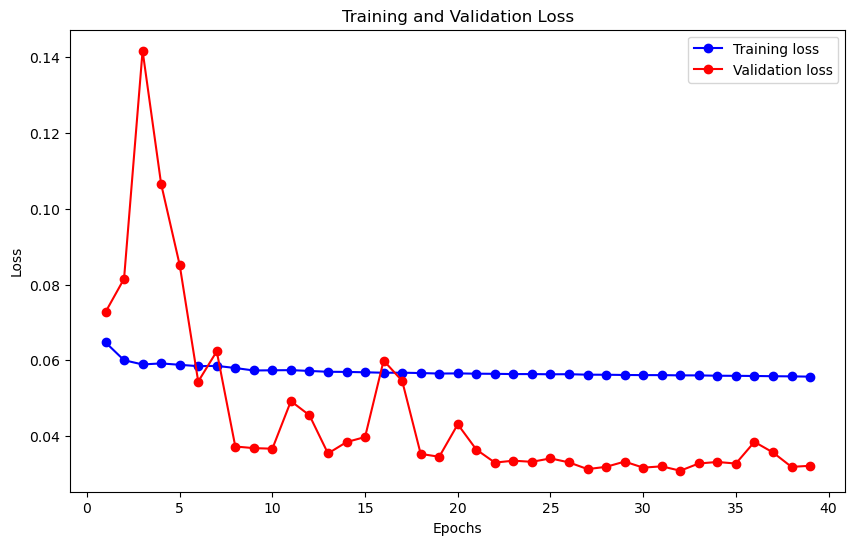

In [117]:
loss = history_128.history['loss']
val_loss = history_128.history['val_loss']

epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [108]:
generated_images_128 = encoder_decoder_128.predict(one_two_eight_test_masked[:])
image_with_center_128 = insert_generated_patch(one_two_eight_test_masked, generated_images_128, 32, 128, 'center')

188/188 [==============================] - 20s 106ms/step


#### Visulize test set for 128 with 32 mask

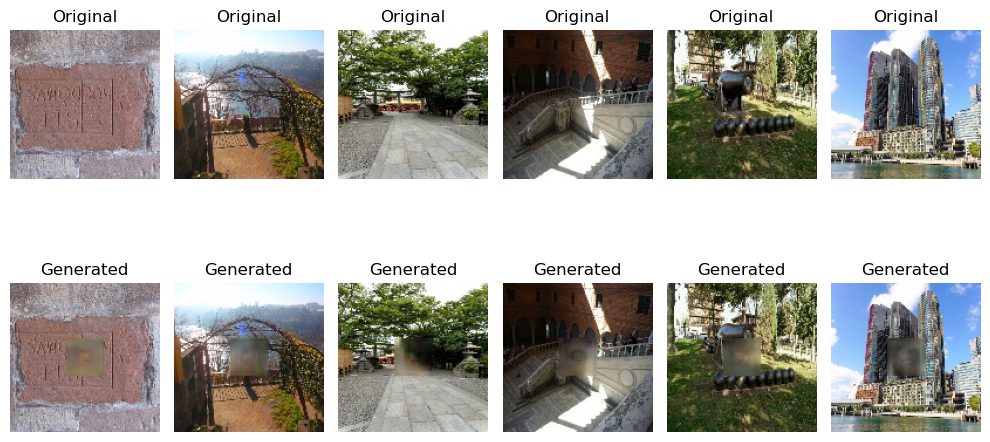

Average MSE: 0.030856862664222717


In [114]:
num_images = 6

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(one_two_eight_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center_128[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_images = len(one_two_eight_test)
mse_values = []
for i in range(num_images):
    mse_values.append(mse(one_two_eight_test_masks[i], generated_images_128[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')

#### Visulize training set for 128 with 32 mask

In [110]:
generated_images_128_train = encoder_decoder_128.predict(one_two_eight_train_masked[:])
image_with_center_128_train = insert_generated_patch(one_two_eight_train_masked, generated_images_128_train, 32, 128, 'center')

750/750 [==============================] - 79s 105ms/step


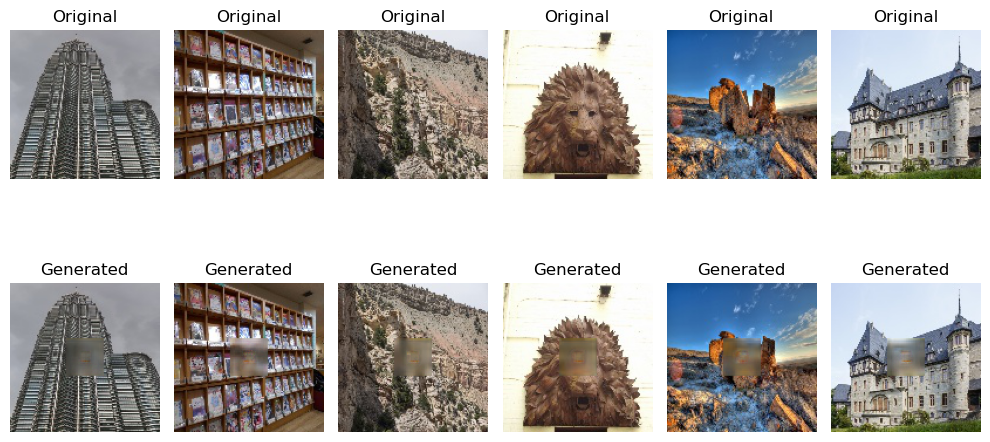

Average MSE: 0.11007044464349747


In [115]:
num_images = 6

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(one_two_eight_train[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center_128_train[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_images = len(one_two_eight_train)
mse_values = []
for i in range(num_images):
    mse_values.append(mse(one_two_eight_train_masks[i], generated_images_128_train[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')

# Train One category

In [131]:
category = 9
cifar10_x_train_truck = cifar10_x_train[cifar10_y_train.flatten() == category]
cifar10_x_test_truck = cifar10_x_test[cifar10_y_test.flatten() == category]

mask_size = 16  # Size of the mask
location = 'center'  # Location where the mask will be applied

cifar10_x_train_truck_center_masked, cifar10_x_train_truck_center_masks = apply_mask_and_get_small_masks(cifar10_x_train_truck, mask_size, location)
cifar10_x_test_truck_center_masked, cifar10_x_test_truck_center_masks = apply_mask_and_get_small_masks(cifar10_x_test_truck, mask_size, location)


In [133]:
encoder_decoder_32_truck = build_encoder_decoder_32()
encoder_decoder_32_truck.compile(optimizer='adam', loss='mse')
history_32_truck = encoder_decoder_32_truck.fit(
    cifar10_x_train_truck_center_masked, 
    cifar10_x_train_truck_center_masks,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(cifar10_x_test_truck_center_masked, cifar10_x_test_truck_center_masks),
    callbacks=[early_stopping] 
)

Epoch 1/30
40/40 [==============================] - 5s 90ms/step - loss: 0.0534 - val_loss: 0.0673
Epoch 2/30
40/40 [==============================] - 3s 66ms/step - loss: 0.0370 - val_loss: 0.0864
Epoch 3/30
40/40 [==============================] - 3s 63ms/step - loss: 0.0336 - val_loss: 0.0914
Epoch 4/30
40/40 [==============================] - 3s 69ms/step - loss: 0.0322 - val_loss: 0.1011
Epoch 5/30
40/40 [==============================] - 3s 64ms/step - loss: 0.0310 - val_loss: 0.1037
Epoch 6/30
40/40 [==============================] - 3s 66ms/step - loss: 0.0300 - val_loss: 0.1015
Epoch 7/30
40/40 [==============================] - 2s 62ms/step - loss: 0.0290 - val_loss: 0.1117
Epoch 8/30
40/40 [==============================] - 3s 67ms/step - loss: 0.0279 - val_loss: 0.1140


In [134]:
generated_images_32_test_truck = encoder_decoder_32_truck.predict(cifar10_x_test_truck_center_masked[:])
image_with_center_32_test_truck = insert_generated_patch(cifar10_x_test_truck_center_masked, generated_images_32_test_truck, 16, 32, 'center')

32/32 [==============================] - 1s 15ms/step


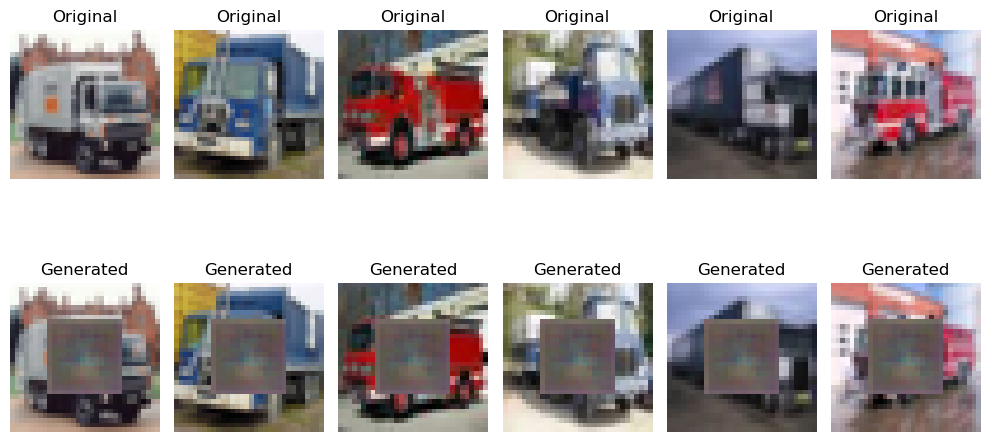

Average MSE: 0.06727316975593567


In [137]:
num_images = 6

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(cifar10_x_test_truck[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center_32_test_truck[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_images = len(cifar10_x_test_truck_center_masks)
mse_values = []
for i in range(num_images):
    mse_values.append(mse(cifar10_x_test_truck_center_masks[i], generated_images_32_test_truck[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')

## general model extract one category image and its MSE

In [ ]:
category = 9

y_test_flattened = y_test.flatten()    # Flatten y_test to make it a 1D array

# Find indices where y_test is 9 (assuming 9 corresponds to 'truck')
truck_indices = [i for i, label in enumerate(y_test_flattened) if label == category]

# Display up to the first 10 truck images
num_truck_images = len(truck_indices)


mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
print(len(mse_values))
print(f'Average MSE: {average_mse}')


num_truck_images = 10
fig, axes = plt.subplots(num_truck_images, 2, figsize=(10, 3 * num_truck_images))
for i in range(num_truck_images):
    truck_index = truck_indices[i]

    # Display original image
    ax = axes[i, 0]
    ax.imshow(x_test[truck_index])
    ax.set_title(f"Original Truck {i+1}")
    ax.axis("off")

    # Display generated (reconstructed) image
    ax = axes[i, 1]
    ax.imshow(image_with_center[truck_index])
    ax.set_title(f"Generated Truck {i+1}")
    ax.axis("off")
plt.tight_layout()
plt.show()

##  First 20 image in CiFar 10

In [ ]:
generated_images = encoder_decoder.predict(x_test_removed[:])

image_with_center = insert_generated_center(x_test_removed[:], generated_images)

# Select a few images to display
num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_truck_images = len(x_test)
mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')

## tranning set

In [ ]:
generated_images = encoder_decoder.predict(x_train_removed[:])

image_with_center = insert_generated_center(x_train_removed[:], generated_images)

num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_train[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_images = len(x_train)
mse_values = []
for i in range(num_images):
    mse_values.append(mse(x_train[i], image_with_center[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')

## Mask lower right corner

In [ ]:
def remove_and_return_lower_right_corner(imgs, mask_size):
    masked_imgs = imgs.copy()
    height, width = imgs.shape[1], imgs.shape[2]
    
    # Calculate the starting indices for the rows (height) and columns (width)
    start_row = max(height - mask_size, 0)
    start_col = max(width - mask_size, 0)
    
    # Extract the lower right corner
    lower_right_corners = imgs[:, start_row:, start_col:, :].copy()
    
    # Set the lower right corner to zero in the masked images
    masked_imgs[:, start_row:, start_col:, :] = 0
    
    return masked_imgs, lower_right_corners

# Function usage
mask_size = 16  # for example, to remove an 8x8 patch from the lower right corner
x_train_masked, x_train_corners = remove_and_return_lower_right_corner(x_train, mask_size)
x_test_masked, x_test_corners = remove_and_return_lower_right_corner(x_test, mask_size)
print(x_train[0].shape)
print(x_train_masked[0].shape)
print(x_train_corners[0].shape)

In [ ]:
def insert_generated_corner(original_images, generated_corners, corner_size=16):
    # Calculate start indices for the rows (height) and columns (width)
    start_row = original_images.shape[1] - corner_size
    start_col = original_images.shape[2] - corner_size
    
    # Ensure the indices are within the image dimensions
    if start_row < 0: start_row = 0
    if start_col < 0: start_col = 0
    
    # Make a copy of the original images to avoid modifying the original array
    images_with_corners = np.copy(original_images)

    # Replace the lower right corner of each image with the generated patch
    images_with_corners[:, start_row:, start_col:, :] = generated_corners

    return images_with_corners

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(x_train[i])
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(x_train_masked[i])
    axs[1, i].set_title('Center Removed')
    axs[1, i].axis('off')

    axs[2, i].imshow(x_train_corners[i])
    axs[2, i].set_title('Mask')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
encoder_decoder_1 = build_encoder_decoder()
encoder_decoder_1.compile(optimizer='adam', loss='mse')
encoder_decoder_1.fit(x_train_masked, x_train_corners,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_masked, x_test_corners))

In [ ]:
generated_images = encoder_decoder_1.predict(x_test_masked[:])

image_with_center = insert_generated_corner(x_test_masked[:], generated_images)

In [ ]:
num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
num_truck_images = len(x_test)
mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
print(len(mse_values))
print(f'Average MSE: {average_mse}')

## Mask upper left

In [ ]:
def remove_and_return_upper_left_corner(imgs, mask_size):
    masked_imgs = imgs.copy()
    
    # The starting indices for the upper left corner are both 0
    start_row = 0
    start_col = 0
    
    # Extract the upper left corner
    upper_left_corners = imgs[:, start_row:start_row+mask_size, start_col:start_col+mask_size, :].copy()
    
    # Set the upper left corner to zero in the masked images
    masked_imgs[:, start_row:start_row+mask_size, start_col:start_col+mask_size, :] = 0
    
    return masked_imgs, upper_left_corners

# Function usage
mask_size = 16  # for example, to remove a 16x16 patch from the upper left corner
x_train_masked, x_train_corners = remove_and_return_upper_left_corner(x_train, mask_size)
x_test_masked, x_test_corners = remove_and_return_upper_left_corner(x_test, mask_size)

# Shapes of the original, masked, and corner images
print(x_train[0].shape)
print(x_train_masked[0].shape)
print(x_train_corners[0].shape)

In [ ]:
def insert_generated_upper_left_corner(original_images, generated_corners, corner_size=16):
    # The start indices for the upper left corner are both 0
    start_row = 0
    start_col = 0
    
    # Make a copy of the original images to avoid modifying the original array
    images_with_upper_left_corners = np.copy(original_images)

    # Replace the upper left corner of each image with the generated patch
    # Ensure that the generated_corners array matches the dimensions where it's being inserted
    images_with_upper_left_corners[:, start_row:start_row+corner_size, start_col:start_col+corner_size, :] = generated_corners

    return images_with_upper_left_corners

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(x_train[i])
    axs[0, i].set_title('Original')
    axs[0, i].axis('off')

    axs[1, i].imshow(x_train_masked[i])
    axs[1, i].set_title('Center Removed')
    axs[1, i].axis('off')

    axs[2, i].imshow(x_train_corners[i])
    axs[2, i].set_title('Mask')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

encoder_decoder_2 = build_encoder_decoder()
# Define early stopping callback
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitors the validation loss
#     patience=5,         # Number of epochs with no improvement after which training will be stopped
#     verbose=1,          # To log when training is stopped
#     restore_best_weights=True  # Restores model weights from the epoch with the minimum validation loss
# )

# Compile your model
encoder_decoder_2.compile(optimizer='adam', loss='mse')

# Fit the model with the early stopping callback
history = encoder_decoder_2.fit(
    x_train_masked, x_train_corners,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_masked, x_test_corners),
#     callbacks=[early_stopping]  # Add early stopping callback here
)


In [ ]:
generated_images = encoder_decoder_2.predict(x_test_masked[:])

image_with_center = insert_generated_upper_left_corner(x_test_masked[:], generated_images)

num_images = 5

fig, axes = plt.subplots(2, num_images, figsize=(10, 1 * num_images))
for i in range(num_images):
    # Display original image
    ax = axes[0, i]
    ax.imshow(x_test[i])
    ax.set_title("Original")
    ax.axis("off")


    # Display generated (reconstructed) image
    ax = axes[1, i]
    ax.imshow(image_with_center[i])
    ax.set_title("Generated")
    ax.axis("off")

plt.tight_layout()
plt.show()
num_truck_images = len(x_test)
mse_values = []
for i in range(num_truck_images):
    mse_values.append(mse(x_test[i], image_with_center[i]))
average_mse = np.mean(mse_values)
#print(len(mse_values))
print(f'Average MSE: {average_mse}')